<h2 align=right style="line-height:200%;font-family:vazir;color:#0099cc">
<font face="vazir" color="#0099cc">
۰) وارد کردن کتابخانه‌های مورد نیاز (Logistic Regression)
</font>
</h2>

<p dir=rtl style="direction: rtl; text-align: justify; line-height:200%; font-family:vazir; font-size:medium">
<font face="vazir" size=3>
در این نوتبوک هدف ما آموزش و تنظیم (Tuning) مدل <b>Logistic Regression</b> است.  
لجستیک رگرشن یک مدل خطی برای طبقه‌بندی است که به عنوان یک مدل پایه (Baseline) بسیار رایج و قابل دفاع محسوب می‌شود.
<br><br>
نکته مهم این است که Logistic Regression نسبت به مقیاس ویژگی‌ها حساس است؛ بنابراین در این نوتبوک از <b>Scaling</b> (مانند <code>MinMaxScaler</code> یا StandardScaler) داخل <code>Pipeline</code> استفاده می‌کنیم تا:
<br>
- ویژگی‌ها هم‌مقیاس شوند،
<br>
- و در Cross-Validation نشت اطلاعات (Data Leakage) رخ ندهد.
</font>
</p>


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import f1_score, classification_report, confusion_matrix, make_scorer


<h2 align=right style="line-height:200%;font-family:vazir;color:#0099cc">
<font face="vazir" color="#0099cc">
۱) خواندن داده‌های پیش‌پردازش‌شده
</font>
</h2>

<p dir=rtl style="direction: rtl; text-align: justify; line-height:200%; font-family:vazir; font-size:medium">
<font face="vazir" size=3>
در نوتبوک پیش‌پردازش، داده‌ها پاکسازی و به فرم عددی مناسب برای مدل‌سازی تبدیل شده‌اند.  
در این نوتبوک فقط روی مدل Logistic Regression تمرکز می‌کنیم؛ بنابراین داده آماده را از فایل می‌خوانیم تا ساختار پروژه مرتب و قابل توسعه باشد.
</font>
</p>


In [2]:
train_data = pd.read_csv("../../data/train_processed.csv")
print("train:", train_data.shape)
train_data.head()


train: (100380, 18)


,ReserveStatus,Male,Price,From,To,Domestic,VehicleClass,TripReason,Cancel,TicketPerOrder,family,Departure_Created,DepartureMonth,Bus,InternationalPlane,Plane,Train,Discount
0,5,True,6565575.0,217.0,80.0,1,0.0,1,0,3,False,10,11,False,False,True,False,True
1,5,True,9500000.0,171.0,80.0,1,0.0,0,0,2,True,2,8,False,False,True,False,False
2,3,False,2000000.0,135.0,37.0,1,1.0,1,0,3,False,0,9,True,False,False,False,False
3,2,False,40000.0,64.0,85.0,1,1.0,0,0,6,True,0,6,False,False,False,True,False
4,3,True,1130000.0,68.0,244.0,1,1.0,0,0,1,False,1,6,True,False,False,False,False


<h2 align=right style="line-height:200%;font-family:vazir;color:#0099cc">
<font face="vazir" color="#0099cc">
۲) جدا کردن ویژگی‌ها (X) و متغیر هدف (y)
</font>
</h2>

<p dir=rtl style="direction: rtl; text-align: justify; line-height:200%; font-family:vazir; font-size:medium">
<font face="vazir" size=3>
برای آموزش مدل باید ستون هدف <code>TripReason</code> را به عنوان y جدا کنیم و سایر ستون‌ها را به عنوان ویژگی‌های ورودی X در نظر بگیریم.  
این کار باعث می‌شود ورودی مدل دقیقاً شامل ویژگی‌ها باشد و از بروز خطای مفهومی جلوگیری شود.
</font>
</p>


In [3]:
X = train_data.drop(columns=["TripReason"])
y = train_data["TripReason"]

X_train, X_val, y_train, y_val = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print(X_train.shape, X_val.shape)


(80304, 17) (20076, 17)


<h2 align=right style="line-height:200%;font-family:vazir;color:#0099cc">
<font face="vazir" color="#0099cc">
۳) تقسیم داده به Train و Validation
</font>
</h2>

<p dir=rtl style="direction: rtl; text-align: justify; line-height:200%; font-family:vazir; font-size:medium">
<font face="vazir" size=3>
برای ارزیابی واقعی مدل، بخشی از داده را به عنوان Validation کنار می‌گذاریم.  
همچنین با استفاده از <code>stratify</code> نسبت کلاس‌ها در Train و Validation مشابه می‌ماند و ارزیابی منصفانه‌تر می‌شود.
</font>
</p>


<h2 align=right style="line-height:200%;font-family:vazir;color:#0099cc">
<font face="vazir" color="#0099cc">
۴) ساخت Pipeline (Scaling + Logistic Regression)
</font>
</h2>

<p dir=rtl style="direction: rtl; text-align: justify; line-height:200%; font-family:vazir; font-size:medium">
<font face="vazir" size=3>
Logistic Regression یک مدل خطی است و در فرآیند یادگیری به مقیاس ویژگی‌ها حساس است؛  
اگر یک ویژگی دامنه بسیار بزرگ‌تری داشته باشد، می‌تواند روی یادگیری اثر غالب بگذارد.
<br><br>
به همین دلیل از Scaling استفاده می‌کنیم.  
همچنین Scaling را داخل <code>Pipeline</code> قرار می‌دهیم تا در Cross-Validation، scaler فقط روی داده Train هر fold fit شود و نشت اطلاعات (Data Leakage) رخ ندهد.
</font>
</p>


In [4]:
log_pipe = Pipeline(steps=[
    ("scaler", MinMaxScaler()),
    ("model", LogisticRegression(max_iter=5000))
])


<h2 align=right style="line-height:200%;font-family:vazir;color:#0099cc">
<font face="vazir" color="#0099cc">
۵) معیار ارزیابی: Macro F1-Score
</font>
</h2>

<p dir=rtl style="direction: rtl; text-align: justify; line-height:200%; font-family:vazir; font-size:medium">
<font face="vazir" size=3>
برای ارزیابی مدل از <code>F1-Score</code> استفاده می‌کنیم چون معیار داوری همین است.  
در این نوتبوک از <b>Macro-F1</b> استفاده می‌کنیم تا هر کلاس وزن برابر داشته باشد و در صورت نامتوازن بودن داده، مدل فقط روی کلاس غالب خوب عمل نکند.
</font>
</p>


In [5]:
f1_macro = make_scorer(f1_score, average="macro")
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)


In [6]:
C_list = [0.01, 0.03, 0.1, 0.3, 1, 3, 10, 30]
mean_scores = []

for C in C_list:
    log_pipe.set_params(model__C=C, model__solver="lbfgs")
    scores = cross_val_score(log_pipe, X_train, y_train, cv=cv, scoring=f1_macro)
    mean_scores.append(scores.mean())
    print(f"C={C:<5} => CV Macro-F1: {scores.mean():.4f} (+/- {scores.std():.4f})")

best_C = C_list[int(np.argmax(mean_scores))]
print("\nBest C (L2, lbfgs):", best_C)

C=0.01  => CV Macro-F1: 0.7267 (+/- 0.0031)
C=0.03  => CV Macro-F1: 0.7414 (+/- 0.0027)
C=0.1   => CV Macro-F1: 0.7560 (+/- 0.0038)
C=0.3   => CV Macro-F1: 0.7622 (+/- 0.0035)
C=1     => CV Macro-F1: 0.7651 (+/- 0.0030)
C=3     => CV Macro-F1: 0.7660 (+/- 0.0028)
C=10    => CV Macro-F1: 0.7665 (+/- 0.0029)
C=30    => CV Macro-F1: 0.7666 (+/- 0.0029)

Best C (L2, lbfgs): 30


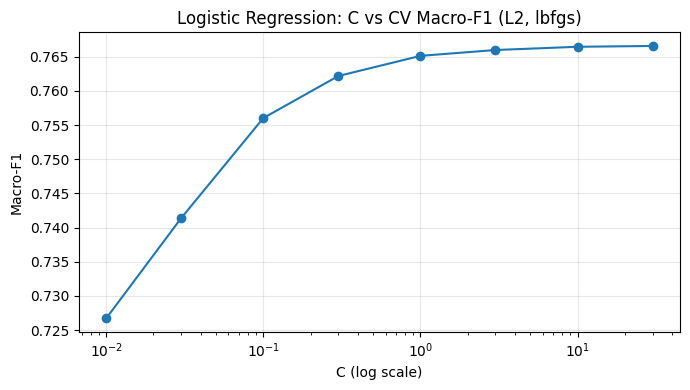

In [7]:
plt.figure(figsize=(7,4))
plt.plot(C_list, mean_scores, marker="o")
plt.xscale("log")
plt.title("Logistic Regression: C vs CV Macro-F1 (L2, lbfgs)")
plt.xlabel("C (log scale)")
plt.ylabel("Macro-F1")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


<h2 align=right style="line-height:200%;font-family:vazir;color:#0099cc">
<font face="vazir" color="#0099cc">
۶) تنظیم پارامترهای Logistic Regression با Cross-Validation
</font>
</h2>

<p dir=rtl style="direction: rtl; text-align: justify; line-height:200%; font-family:vazir; font-size:medium">
<font face="vazir" size=3>
برای اینکه تست ما واقعی باشد، فقط یک بار مدل را آموزش نمی‌دهیم.  
پارامترهای مهم Logistic Regression را بررسی می‌کنیم:
<br>
- <code>C</code>: میزان منظم‌سازی (Regularization).  
C کوچک‌تر یعنی منظم‌سازی بیشتر (مدل ساده‌تر)، و C بزرگ‌تر یعنی منظم‌سازی کمتر (مدل پیچیده‌تر).
<br>
- <code>penalty</code>: نوع منظم‌سازی (L1 یا L2)
<br>
- <code>solver</code>: الگوریتم بهینه‌سازی که باید با penalty سازگار باشد.
<br><br>
برای انتخاب بهترین ترکیب، از Cross-Validation استفاده می‌کنیم تا نتیجه به یک تقسیم‌بندی خاص وابسته نباشد.
</font>
</p>


In [8]:
C_list = [0.01, 0.1, 1, 10]
settings = [
    {"penalty": "l2", "solver": "lbfgs"},
    {"penalty": "l2", "solver": "liblinear"},
    {"penalty": "l1", "solver": "liblinear"},
]

results = []

for s in settings:
    for C in C_list:
        log_pipe.set_params(
            model__C=C,
            model__penalty=s["penalty"],
            model__solver=s["solver"]
        )
        scores = cross_val_score(log_pipe, X_train, y_train, cv=cv, scoring=f1_macro)
        results.append({
            "C": C,
            "penalty": s["penalty"],
            "solver": s["solver"],
            "cv_mean_f1": scores.mean(),
            "cv_std_f1": scores.std()
        })

results_df = pd.DataFrame(results).sort_values("cv_mean_f1", ascending=False)
results_df.head(10)


/home/matltin/Project/python/AI-FinalProject-Billitio-ML/venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1135: FutureWarning: 'penalty' was deprecated in version 1.8 and will be removed in 1.10. To avoid this warning, leave 'penalty' set to its default value and use 'l1_ratio' or 'C' instead. Use l1_ratio=0 instead of penalty='l2', l1_ratio=1 instead of penalty='l1', and C=np.inf instead of penalty=None.
  warnings.warn(
/home/matltin/Project/python/AI-FinalProject-Billitio-ML/venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1135: FutureWarning: 'penalty' was deprecated in version 1.8 and will be removed in 1.10. To avoid this warning, leave 'penalty' set to its default value and use 'l1_ratio' or 'C' instead. Use l1_ratio=0 instead of penalty='l2', l1_ratio=1 instead of penalty='l1', and C=np.inf instead of penalty=None.
  warnings.warn(
/home/matltin/Project/python/AI-FinalProject-Billitio-ML/venv/lib/python3.12/site-packages/sklearn/linear_mode

,C,penalty,solver,cv_mean_f1,cv_std_f1
10,1.00,l1,liblinear,0.766524,0.002922
3,10.00,l2,lbfgs,0.766452,0.002911
11,10.00,l1,liblinear,0.766415,0.002856
7,10.00,l2,liblinear,0.766340,0.002972
9,0.10,l1,liblinear,0.765708,0.003132
2,1.00,l2,lbfgs,0.765122,0.002950
6,1.00,l2,liblinear,0.765008,0.002938
1,0.10,l2,lbfgs,0.756015,0.003761
5,0.10,l2,liblinear,0.755836,0.003887
8,0.01,l1,liblinear,0.754902,0.003828


In [9]:
best_row = results_df.iloc[0]
best_C = best_row["C"]
best_penalty = best_row["penalty"]
best_solver = best_row["solver"]

best_row


C                   1.0
penalty              l1
solver        liblinear
cv_mean_f1     0.766524
cv_std_f1      0.002922
Name: 10, dtype: object

<h2 align=right style="line-height:200%;font-family:vazir;color:#0099cc">
<font face="vazir" color="#0099cc">
۷) آموزش بهترین مدل و ارزیابی نهایی
</font>
</h2>

<p dir=rtl style="direction: rtl; text-align: justify; line-height:200%; font-family:vazir; font-size:medium">
<font face="vazir" size=3>
پس از انتخاب بهترین پارامترها، مدل نهایی را با همان تنظیمات آموزش می‌دهیم و روی داده Validation ارزیابی می‌کنیم.  
در کنار F1-Score، ماتریس درهم‌ریختگی و گزارش طبقه‌بندی را نیز نمایش می‌دهیم تا رفتار مدل در هر کلاس مشخص شود.
</font>
</p>


In [10]:
final_log = Pipeline(steps=[
    ("scaler", MinMaxScaler()),
    ("model", LogisticRegression(
        C=float(best_C),
        penalty=str(best_penalty),
        solver=str(best_solver),
        max_iter=5000
    ))
])

final_log.fit(X_train, y_train)
pred = final_log.predict(X_val)

print("Validation Macro-F1:", f1_score(y_val, pred, average="macro"))
print("\nConfusion Matrix:\n", confusion_matrix(y_val, pred))
print("\nClassification Report:\n", classification_report(y_val, pred))


/home/matltin/Project/python/AI-FinalProject-Billitio-ML/venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1135: FutureWarning: 'penalty' was deprecated in version 1.8 and will be removed in 1.10. To avoid this warning, leave 'penalty' set to its default value and use 'l1_ratio' or 'C' instead. Use l1_ratio=0 instead of penalty='l2', l1_ratio=1 instead of penalty='l1', and C=np.inf instead of penalty=None.
  warnings.warn(
/home/matltin/Project/python/AI-FinalProject-Billitio-ML/venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1160: UserWarning: Inconsistent values: penalty=l1 with l1_ratio=0.0. penalty is deprecated. Please use l1_ratio only.
  warnings.warn(


Validation Macro-F1: 0.7644218839281358

Confusion Matrix:
 [[ 5505  3316]
 [ 1167 10088]]

Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.62      0.71      8821
           1       0.75      0.90      0.82     11255

    accuracy                           0.78     20076
   macro avg       0.79      0.76      0.76     20076
weighted avg       0.78      0.78      0.77     20076

